<a href="https://colab.research.google.com/github/arpitsolanki/FPLBot/blob/main/Fantasy_League.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import os
import pandas as pd
import requests
import json
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xgboost as xgboost
import datetime

from sklearn.model_selection import train_test_split #Splitting data for model training
from sklearn.ensemble import RandomForestClassifier #RF
from sklearn.preprocessing import LabelEncoder#Label Encoder
from sklearn.preprocessing import OneHotEncoder#One Hot Encoder
from sklearn.metrics import confusion_matrix#Confusion Matrix
from sklearn.metrics import roc_curve#RoC Curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve#Metrics Functions


In [66]:
#Define GW for predictions
GW=16

#Fantasy API Calls to pull historic player stats
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
response = requests.get(url)
response = json.loads(response.content)

#Fixtures for upcoming game weeks
fix_url = 'https://fantasy.premierleague.com/api/fixtures?event='+str(GW)
fix_response = requests.get(fix_url)
fix_response = json.loads(fix_response.content)

In [67]:
def get(url):
    response = requests.get(url)
    return json.loads(response.content)
                      

In [68]:
players = response['elements']
teams = response['teams']
events = response['events']
#fixtures = fix_response['fixtures']

players_df = pd.DataFrame(players)
teams_df = pd.DataFrame(teams)
events_df = pd.DataFrame(events)
fixtures_df=pd.DataFrame(fix_response)
fixtures_df


,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id
0,2128439,16,True,True,152,2020-12-28T15:00:00Z,90,False,True,9,1,6,1,"[{'identifier': 'goals_scored', 'a': [{'value'...",4,3,59049
1,2128438,16,True,True,151,2020-12-28T17:30:00Z,90,False,True,2,1,5,1,"[{'identifier': 'goals_scored', 'a': [{'value'...",3,4,59048
2,2128436,16,True,True,149,2020-12-29T18:00:00Z,90,False,True,1,1,3,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",3,2,59046
3,2128437,16,True,True,150,2020-12-29T18:00:00Z,90,False,True,15,0,4,1,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,2,59047
4,2128443,16,True,True,156,2020-12-29T18:00:00Z,90,False,True,19,0,16,0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",3,3,59053
5,2128445,16,True,True,158,2020-12-29T18:00:00Z,90,False,True,10,5,18,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,2,59055
6,2128441,16,True,True,154,2020-12-29T20:00:00Z,90,False,True,20,0,13,1,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",3,4,59051
7,2128442,16,True,True,155,2020-12-30T20:00:00Z,90,False,True,11,0,14,0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",4,3,59052


In [69]:
events_df


,id,name,deadline_time,average_entry_score,finished,data_checked,highest_scoring_entry,deadline_time_epoch,deadline_time_game_offset,highest_score,is_previous,is_current,is_next,chip_plays,most_selected,most_transferred_in,top_element,top_element_info,transfers_made,most_captained,most_vice_captained
0,1,Gameweek 1,2020-09-12T10:00:00Z,50,True,True,4761681.0,1599904800,0,142.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 112843}...",259.0,12.0,254.0,"{'id': 254, 'points': 20}",0,4.0,4.0
1,2,Gameweek 2,2020-09-19T10:00:00Z,59,True,True,6234344.0,1600509600,0,165.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 94615},...",259.0,302.0,390.0,"{'id': 390, 'points': 24}",14637421,4.0,254.0
2,3,Gameweek 3,2020-09-26T10:00:00Z,43,True,True,6223553.0,1601114400,0,119.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 86797},...",259.0,164.0,224.0,"{'id': 224, 'points': 17}",20387878,272.0,254.0
3,4,Gameweek 4,2020-10-03T10:00:00Z,48,True,True,6563000.0,1601719200,0,160.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 82267},...",272.0,164.0,37.0,"{'id': 37, 'points': 24}",14570655,254.0,272.0
4,5,Gameweek 5,2020-10-17T10:00:00Z,60,True,True,7124486.0,1602928800,0,136.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 80554},...",164.0,390.0,117.0,"{'id': 117, 'points': 16}",18391649,390.0,254.0
5,6,Gameweek 6,2020-10-23T17:30:00Z,48,True,True,4289106.0,1603474200,0,123.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 58697},...",164.0,388.0,202.0,"{'id': 202, 'points': 17}",12707803,254.0,390.0
6,7,Gameweek 7,2020-10-30T18:30:00Z,53,True,True,6909580.0,1604082600,0,131.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 68374},...",390.0,232.0,370.0,"{'id': 370, 'points': 17}",8811577,388.0,390.0
7,8,Gameweek 8,2020-11-06T16:00:00Z,55,True,True,601887.0,1604678400,0,133.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 76086},...",390.0,110.0,302.0,"{'id': 302, 'points': 17}",9570772,388.0,390.0
8,9,Gameweek 9,2020-11-21T11:00:00Z,55,True,True,1800361.0,1605956400,0,119.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 76389},...",164.0,302.0,164.0,"{'id': 164, 'points': 13}",12576286,302.0,390.0
9,10,Gameweek 10,2020-11-27T18:30:00Z,44,True,True,4357171.0,1606501800,0,117.0,False,False,False,"[{'chip_name': 'bboost', 'num_played': 48490},...",164.0,468.0,275.0,"{'id': 275, 'points': 21}",8328156,224.0,164.0


In [70]:
#Dataset from Fivethirtyeight providing projected scores for the upcoming game week
spi_data = pd.read_csv('https://projects.fivethirtyeight.com/soccer-api/club/spi_matches_latest.csv')
spi_data=spi_data.loc[(spi_data['season']==2020) & (spi_data['league']=='Barclays Premier League')]
#spi_data

#Team mapping file
team_mapping_spi=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/FPLBot/main/team_mapping.csv')
#team_mapping_spi

#Add team_ids to the 538 dataset to make it compatible with FPL API datasets
spi_data_name=pd.merge(left=spi_data,right=team_mapping_spi,how='inner',left_on='team1',right_on='team')
spi_data_name=spi_data_name.rename(columns={"id": "team1_id"})

spi_data_name=pd.merge(left=spi_data_name,right=team_mapping_spi,how='inner',left_on='team2',right_on='team')
spi_data_name=spi_data_name.rename(columns={"id": "team2_id"})
#spi_data_name

In [71]:
players_df

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,0.0,0.0,37605,0,0,-2,2,0,3,0.0,0.0,0,Mesut,0.0,1,False,Not included in Arsenal's 25-man Premier Leagu...,2020-10-20T22:30:18.118477Z,68,37605.jpg,0.0,Özil,0.6,False,None,n,1,3,0,3405,5,52938,91,0.0,0.0,Özil,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,616,247,616,247,616,247,616,247,NaN,,NaN,,NaN,
1,0.0,0.0,39476,0,0,-2,2,0,2,0.0,0.0,0,Sokratis,0.0,2,False,Not included in Arsenal's 25-man Premier Leagu...,2020-10-21T10:30:18.546407Z,48,39476.jpg,0.0,Papastathopoulos,0.1,False,None,n,1,3,0,10255,5,18839,19,0.0,0.0,Sokratis,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,574,212,565,212,553,208,577,212,NaN,,NaN,,NaN,
2,75.0,75.0,41270,0,0,-1,1,0,2,1.0,0.6,0,David,0.3,3,False,Illness - 75% chance of playing,2020-12-26T18:00:15.638627Z,54,41270.jpg,1.1,Luiz Moreira Marinho,0.7,False,None,d,1,3,9,39082,41,89220,836,0.1,1.7,David Luiz,479,0,0,0,9,0,0,0,0,0,0,0,70,99.4,25.8,40.0,16.5,260,100,296,93,259,79,295,97,NaN,,4.0,,NaN,
3,100.0,100.0,54694,0,0,-6,6,1,3,3.5,3.0,3,Pierre-Emerick,2.5,4,False,,2020-12-19T20:30:20.434896Z,114,54694.jpg,3.6,Aubameyang,7.3,False,None,a,1,3,50,498705,4867,3142668,5871,0.2,4.4,Aubameyang,1256,3,1,4,16,1,0,0,2,0,0,4,146,191.2,208.8,401.0,80.1,147,54,61,41,27,14,38,24,NaN,,NaN,,1.0,
4,100.0,100.0,58822,0,0,-4,4,0,2,1.2,0.7,0,Cédric,0.2,5,False,,2020-09-23T09:00:14.881983Z,46,58822.jpg,1.0,Soares,0.2,False,None,a,1,3,1,3880,32,34538,123,0.0,0.2,Cédric,5,0,0,0,0,0,0,0,0,0,0,0,3,0.0,0.0,0.0,0.0,561,208,549,208,532,202,564,208,NaN,,NaN,,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,NaN,NaN,443296,0,0,0,0,0,3,0.0,-0.5,0,Theo,0.0,610,False,,None,45,443296.jpg,0.0,Corbeanu,0.0,False,None,a,20,39,0,100,10,48,16,0.0,0.0,Corbeanu,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,555,217,543,218,526,211,558,217,NaN,,NaN,,NaN,
612,NaN,NaN,232361,0,0,0,0,0,3,0.0,-0.5,0,Taylor,0.0,611,False,,None,45,232361.jpg,0.0,Perry,0.0,False,None,a,20,39,0,270,14,95,17,0.0,0.0,Perry,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,550,213,538,214,521,207,553,213,NaN,,NaN,,NaN,
613,NaN,NaN,245923,0,0,0,0,0,3,0.0,-0.5,0,Luke,0.0,614,False,,None,45,245923.jpg,0.0,Cundle,0.0,False,None,a,20,39,0,127,71,34,23,0.0,0.0,Cundle,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,553,216,541,217,524,210,556,216,NaN,,NaN,,NaN,
614,NaN,NaN,437688,0,0,0,0,0,2,1.2,0.7,0,Lewis,0.0,615,False,,None,40,437688.jpg,0.0,Richards,0.0,False,None,a,20,39,0,81,81,17,17,0.0,0.0,Richards,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,481,186,463,186,432,170,485,186,NaN,,NaN,,NaN,


In [72]:
players_df_filtered=players_df[['web_name','element_type','now_cost','selected_by_percent','points_per_game','team','total_points','minutes','goals_scored','assists','clean_sheets','goals_conceded','yellow_cards','red_cards','bonus','chance_of_playing_next_round']]
players_df_filtered=players_df_filtered.loc[players_df_filtered['minutes']>300]
players_df_filtered['now_cost_mil']=players_df_filtered['now_cost']/10
players_df_filtered['ppm']=players_df_filtered['total_points']/players_df_filtered['now_cost_mil']
players_df_filtered.sort_values(by='ppm',ascending=False,inplace=True)


In [73]:
#players_df_filtered.sort_values(by='total_points',ascending=False)


In [74]:
teams_df_filtered=teams_df[['id','name','short_name','played','points','position','win','draw','loss']]
teams_df_filtered_join=teams_df[['id','name']]


In [75]:
fixtures_df_name=pd.merge(left=fixtures_df,right=teams_df_filtered_join,left_on='team_a',right_on='id',how='left')
fixtures_df_name=fixtures_df_name.rename(columns={"name": "away_team"})
fixtures_df_name=pd.merge(left=fixtures_df_name,right=teams_df_filtered_join,left_on='team_h',right_on='id',how='left')
fixtures_df_name=fixtures_df_name.rename(columns={"name": "home_team"})
fixtures_df_name

,code,event,finished,finished_provisional,id_x,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,id_y,away_team,id,home_team
0,2128439,16,True,True,152,2020-12-28T15:00:00Z,90,False,True,9,1,6,1,"[{'identifier': 'goals_scored', 'a': [{'value'...",4,3,59049,9,Leicester,6,Crystal Palace
1,2128438,16,True,True,151,2020-12-28T17:30:00Z,90,False,True,2,1,5,1,"[{'identifier': 'goals_scored', 'a': [{'value'...",3,4,59048,2,Aston Villa,5,Chelsea
2,2128436,16,True,True,149,2020-12-29T18:00:00Z,90,False,True,1,1,3,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",3,2,59046,1,Arsenal,3,Brighton
3,2128437,16,True,True,150,2020-12-29T18:00:00Z,90,False,True,15,0,4,1,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,2,59047,15,Sheffield Utd,4,Burnley
4,2128443,16,True,True,156,2020-12-29T18:00:00Z,90,False,True,19,0,16,0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",3,3,59053,19,West Ham,16,Southampton
5,2128445,16,True,True,158,2020-12-29T18:00:00Z,90,False,True,10,5,18,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,2,59055,10,Leeds,18,West Brom
6,2128441,16,True,True,154,2020-12-29T20:00:00Z,90,False,True,20,0,13,1,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",3,4,59051,20,Wolves,13,Man Utd
7,2128442,16,True,True,155,2020-12-30T20:00:00Z,90,False,True,11,0,14,0,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",4,3,59052,11,Liverpool,14,Newcastle


In [76]:
df_l=[]
for i in range(GW):
  fix_url = 'https://fantasy.premierleague.com/api/fixtures?event='+str(i+1)
  fix_response = requests.get(fix_url)
  fix_response = json.loads(fix_response.content)
  fixtures_df=pd.DataFrame(fix_response)
  fixtures_df['gw']=i+1
  df_l.append(fixtures_df)
#  print(fix_url)

fixtures_df = pd.concat(df_l, axis=0, ignore_index=True)
fixtures_df_map=fixtures_df[['gw','kickoff_time']].copy()

fixtures_df_map['date']=pd.to_datetime(fixtures_df_map['kickoff_time'], errors='coerce').dt.date

del fixtures_df_map['kickoff_time']
fixtures_df_map=fixtures_df_map.drop_duplicates()
#fixtures_df_map

In [77]:
fixtures_df_name_cur_gw=fixtures_df_name[['home_team','away_team','id','id_y']]
fixtures_df_name_cur_gw.columns=['home_team','away_team','home_id','away_id']



In [78]:
spi_data_name_fil=spi_data_name[['team1','team2','team1_id','team2_id','proj_score1','proj_score2']]
spi_data_name_fil.columns=['team1','team2','home_id','away_id','proj_score1','proj_score2']

spi_gw_scores=pd.merge(left=fixtures_df_name_cur_gw,right=spi_data_name_fil,left_on=['home_id','away_id'],right_on=['home_id','away_id'],how='inner')


In [79]:
players_df_filtered_teams=pd.merge(left=players_df_filtered,right=teams_df_filtered_join,how='inner',left_on='team',right_on='id')
#players_df_filtered_teams

In [80]:
#Read historical fixtures data

team_list=['understat_Arsenal.csv','understat_Aston_Villa.csv','understat_Brighton.csv','understat_Burnley.csv','understat_Chelsea.csv','understat_Crystal_Palace.csv','understat_Everton.csv','understat_Fulham.csv','understat_Leeds.csv','understat_Leicester.csv','understat_Liverpool.csv','understat_Manchester_City.csv','understat_Manchester_United.csv','understat_Newcastle_United.csv','understat_Sheffield_United.csv','understat_Southampton.csv','understat_Tottenham.csv','understat_West_Bromwich_Albion.csv','understat_West_Ham.csv','understat_Wolverhampton_Wanderers.csv']
static='https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/understat/'
df_l=[]

for i in range(20):
  k=static+team_list[i]
  temp=pd.read_csv(k)
 # print(temp.shape[0])
  temp['team']=team_list[i]
  df_l.append(temp)

team_total_data = pd.concat(df_l, axis=0, ignore_index=True)

#team_total_data
#team_mapping_spi
team_total_data_id=pd.merge(left=team_total_data,right=team_mapping_spi,left_on='team',right_on='team_file_name',how='left')
team_total_data_id

team_total_data_id=team_total_data_id[['team_y','id','pts','date','h_a','xG','xGA','deep','deep_allowed','scored','missed']]
# #team_total_data_id
team_total_data_id['date_new']=pd.to_datetime(team_total_data_id['date'], errors='coerce').dt.date

del team_total_data_id['date']
team_total_data_id['cum_pts']=team_total_data_id.groupby(['team_y'])['pts'].cumsum()

#team_total_data_id

team_total_data_id_means = team_total_data_id.join(team_total_data_id.groupby(['id']).expanding().agg({'xG':'mean','xGA': 'mean', 'deep': 'mean', 'deep_allowed': 'mean','scored':'mean','missed':'mean'})
               .reset_index(level=0, drop=True)
               .add_suffix('_roll'))
team_total_data_id_means=team_total_data_id_means.groupby(['id', 'date_new']).last().reset_index()
team_total_data_id_means=team_total_data_id_means[['id','date_new','xG_roll','xGA_roll','deep_roll','deep_allowed_roll','scored_roll','missed_roll']]
team_total_data_id_means
#Create a league standings table
team_total_data_id=pd.merge(left=team_total_data_id,right=fixtures_df_map,left_on='date_new',right_on='date',how='inner')
team_total_data_id.sort_values(by='cum_pts',inplace=True,ascending=False)
team_total_data_id=team_total_data_id[['cum_pts','gw','id','date_new']]
team_total_data_id["rank"] = team_total_data_id.groupby("gw")["cum_pts"].rank("dense", ascending=False)
team_total_data_id.columns=['cum_pts','gw','id','date_new','rank']
#team_total_data_id

team_total_data_id=pd.merge(left=team_total_data_id,right=team_total_data_id_means,left_on=['id','date_new'],right_on=['id','date_new'],how='inner')
del team_total_data_id['date_new']
team_total_data_id['xG_diff']=team_total_data_id['xG_roll']-team_total_data_id['xGA_roll']
team_total_data_id['deep_diff']=team_total_data_id['deep_roll']/(team_total_data_id['deep_roll']+team_total_data_id['deep_allowed_roll'])
team_total_data_id['scored_diff']=team_total_data_id['scored_roll']/(team_total_data_id['scored_roll']+team_total_data_id['missed_roll'])
team_total_data_id=team_total_data_id[['cum_pts','gw','id','rank','xG_diff','deep_diff','scored_diff']]
team_total_data_id
#team_total_data_id.to_csv('team_total_data_id.csv')
#files.download('team_total_data_id.csv')


,cum_pts,gw,id,rank,xG_diff,deep_diff,scored_diff
0,32,15,11,1.0,0.753669,0.781250,0.649123
1,31,14,11,1.0,0.756431,0.765854,0.654545
2,29,15,7,2.0,0.186835,0.444444,0.577778
3,28,13,11,1.0,0.631564,0.770833,0.604167
4,28,15,9,3.0,0.199594,0.511765,0.595745
...,...,...,...,...,...,...,...
289,0,4,8,8.0,-0.838949,0.348837,0.214286
290,0,4,15,8.0,-0.268770,0.500000,0.142857
291,0,4,4,8.0,-0.446754,0.510204,0.272727
292,0,2,4,3.0,0.536675,0.300000,0.333333


In [81]:
#Read Gameweek history

#gw_list=['gw1','gw2','gw3','gw4','gw5','gw6','gw7','gw8','gw9','gw10','gw11','gw12','gw13','gw14','gw15']
gw_list=[]
for i in range(GW-1):
  gw_str='gw'+str(i+1)
  gw_list.append(gw_str)
print(gw_list)

static='https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/'
df_l=[]

for i in range(len(gw_list)):
  k=static+gw_list[i]+'.csv'
  temp=pd.read_csv(k)
  temp['gw']=i+1
  df_l.append(temp)
# print(k)

weekly_data = pd.concat(df_l, axis=0, ignore_index=True)
#weekly_data

weekly_data_team=pd.merge(left=weekly_data,right=teams_df_filtered_join,left_on='opponent_team',right_on='id',how='inner')
weekly_data_team=weekly_data_team.rename(columns={"name_y": "opponent_team_name"})

weekly_data_team=pd.merge(left=weekly_data_team,right=teams_df_filtered_join,left_on='team',right_on='name',how='inner')
weekly_data_team=weekly_data_team.rename(columns={"name_x": "player_name",'id_y':'team_id'})
#weekly_data_team


['gw1', 'gw2', 'gw3', 'gw4', 'gw5', 'gw6', 'gw7', 'gw8', 'gw9', 'gw10', 'gw11', 'gw12', 'gw13', 'gw14', 'gw15']


In [82]:
weekly_data_team.gw.max()

15

In [83]:
#weekly_data_team.iloc[0,33]
#Add the home and away team columns
weekly_data_team['home_team'] = weekly_data_team['team_id']
weekly_data_team['away_team'] = weekly_data_team['team_id']

weekly_data_team.loc[weekly_data_team['was_home'] == True, 'home_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == True, 'team_id']
weekly_data_team.loc[weekly_data_team['was_home'] == True, 'away_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == True, 'opponent_team']

weekly_data_team.loc[weekly_data_team['was_home'] == False, 'home_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == False, 'opponent_team']
weekly_data_team.loc[weekly_data_team['was_home'] == False, 'away_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == False, 'team_id']
#weekly_data_team

weekly_data_team_spi=pd.merge(left=weekly_data_team,right=spi_data_name_fil,left_on=['home_team','away_team'],right_on=['home_id','away_id'],how='inner')
weekly_data_team_spi

#Weekly data remove players who haven't started yet
zero_min=weekly_data_team_spi.groupby(['player_name',]).agg({'minutes':'sum'}).reset_index()
zero_min=zero_min.loc[zero_min['minutes']==0]
#zero_min
#weekly_data_team_spi.player_name.isin(zero_min['player_name']).sum()

weekly_data_team_spi_zero=weekly_data_team_spi[~(weekly_data_team_spi.player_name.isin(zero_min['player_name']))]
# weekly_data_team_spi_zero['team_id']=0
# weekly_data_team_spi_zero.loc[:,'team_id']=weekly_data_team_spi_zero.loc[weekly_data_team_spi_zero['was_home']=True,'home_team']
#weekly_data_team_spi_zero


In [84]:
#Most points in a gameweek
gp=weekly_data.groupby(['name','gw']).agg({'total_points':'sum'}).reset_index()
gp.sort_values(by='total_points',ascending=False)


,name,gw,total_points
3169,Heung-Min Son,2,24
3377,Jack Grealish,4,24
7062,Riyad Mahrez,10,21
3067,Harry Kane,2,21
6100,Mohamed Salah,1,20
...,...,...,...
4188,John Lundstram,14,-2
2451,Erik Pieters,2,-2
6303,Nathaniel Clyne,14,-2
480,Andreas Christensen,2,-3


In [85]:
#Distribution of points scored by players
gp=weekly_data_team_spi_zero.groupby(['total_points']).size().reset_index(name='counts')
#gp.sort_values(by='counts',ascending=False)

fig=px.bar(gp,x='total_points',y='counts',title='Distribution of points scored in gameweek by players')
fig.show()


In [86]:
#Points Distribution by Position
weekly_data_team_spi_zero['point_flag']=0

weekly_data_team_spi_zero.loc[weekly_data_team_spi_zero['total_points']>2,'point_flag']=1
#weekly_data_team_spi_zero

gp=weekly_data_team_spi_zero.groupby(['position','point_flag']).size().reset_index(name='counts')
gp

fig = make_subplots(rows=1, cols=4,specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'},{'type':'domain'}]],subplot_titles=("GK","DEF","MID","FWD"))

fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='GK','point_flag'], values=gp.loc[gp['position']=='GK','counts'], name="GK"),1, 1)
fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='DEF','point_flag'], values=gp.loc[gp['position']=='DEF','counts'], name="DEF"),1, 2)
fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='MID','point_flag'], values=gp.loc[gp['position']=='MID','counts'], name="MID"),1, 3)
fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='FWD','point_flag'], values=gp.loc[gp['position']=='FWD','counts'], name="FW"),1, 4)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Points Distribution by Position")

fig.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [87]:
#weekly_data_team_spi_zero


In [88]:
player_summary=weekly_data_team_spi_zero[['player_name','round','team_id','total_points']]
team_gp=player_summary.groupby(['team_id','round']).agg({'total_points':'sum'}).reset_index()
team_gp.columns=['team_id','round','team_total_points']
team_gp

team_gp['team_total_points_cumsum'] = team_gp.groupby(['team_id'])['team_total_points'].cumsum()
team_gp
del team_gp['team_total_points']
# team_player_gp=player_summary.groupby(['team_id','player_name','round']).agg({'total_points':'sum'}).reset_index()
# team_player_gp.columns=['team_id','player_name','round','team_total_points']
# team_player_gp

# from google.colab import files

# team_player_gp.to_csv('team_player_gp.csv')
# files.download('team_player_gp.csv')


In [89]:
#Feature Engineering
weekly_data_subset=weekly_data_team_spi_zero[['player_name','gw','position','team','round','id_x','team_id','xP','assists','bonus','clean_sheets','goals_scored','goals_conceded','minutes','creativity','ict_index','influence','selected','threat','yellow_cards','red_cards','was_home','home_team','away_team','proj_score1','proj_score2','total_points','point_flag']]
weekly_data_subset=weekly_data_subset.rename(columns={"id_x": "opponent_id"})

#Weekly Cumulative sums
weekly_data_subset.sort_values(by=['player_name','gw'],ascending=True,inplace=True)
gp_cols=weekly_data_subset[['player_name','gw','red_cards','yellow_cards','xP','total_points','bonus','clean_sheets','assists','minutes','influence','creativity','threat','ict_index']]
gp_cols=gp_cols.loc[gp_cols.gw>=GW-4]
gp_cumsum=gp_cols.groupby(['player_name','gw']).sum().groupby('player_name').cumsum().reset_index()

#Weekly Mean Sums
weekly_rolling_means = weekly_data_subset.join(weekly_data_subset.groupby(['player_name']).expanding().agg({'minutes':'mean','influence': 'mean', 'creativity': 'mean', 'threat': 'mean','ict_index':'mean','selected':'mean'})
               .reset_index(level=0, drop=True)
               .add_suffix('_roll'))
weekly_rolling_means=weekly_rolling_means.groupby(['round', 'player_name']).last().reset_index()
weekly_rolling_means=weekly_rolling_means[['player_name','gw','influence_roll', 'creativity_roll', 'threat_roll','ict_index_roll','minutes_roll','selected_roll']]

weekly_data_subset_new=weekly_data_subset[['player_name','gw','position','team','round','team_id','opponent_id','was_home','home_team','away_team','proj_score1','proj_score2','point_flag']].copy()

weekly_data_subset_new['join_key']=0
gw=weekly_data_subset_new['gw']
weekly_data_subset_new.loc[:,'join_key']=gw-1

#Merge cumulative sums
weekly_data_subset_new_agg=pd.merge(left=weekly_data_subset_new,right=weekly_rolling_means,left_on=['player_name','join_key'],right_on=['player_name','gw'],how='inner')

#Merge cumulative means
weekly_data_subset_new_agg=pd.merge(left=weekly_data_subset_new_agg,right=gp_cumsum,left_on=['player_name','join_key'],right_on=['player_name','gw'],how='inner')

#Merge team total ranking stats with home team
weekly_data_subset_new_agg_home=pd.merge(left=weekly_data_subset_new_agg,right=team_total_data_id,left_on=['team_id','join_key'],right_on=['id','gw'])
weekly_data_subset_new_agg_home=weekly_data_subset_new_agg_home.rename(columns={"rank": "team_rank",'cum_pts':'team_pts','xG_diff':'xG_diff_team','scored_diff':'scored_diff_team','deep_diff':'deep_diff_team'})

#Merge team total ranking stats with away team
weekly_data_subset_new_agg_pts=pd.merge(left=weekly_data_subset_new_agg_home,right=team_total_data_id,left_on=['opponent_id','join_key'],right_on=['id','gw'])
weekly_data_subset_new_agg_pts=weekly_data_subset_new_agg_pts.rename(columns={"rank": "opponent_rank",'cum_pts':'opponent_points','xG_diff':'xG_diff_opponent','scored_diff':'scored_diff_opponent','deep_diff':'deep_diff_opponent'})

#Calculate rank and projected score differences for the upcoming fixture
weekly_data_subset_new_agg_pts['rank_diff']=weekly_data_subset_new_agg_pts['team_rank']-weekly_data_subset_new_agg_pts['opponent_rank']
weekly_data_subset_new_agg_pts['proj_score_diff']=weekly_data_subset_new_agg_pts['proj_score1']-weekly_data_subset_new_agg_pts['proj_score2']

#Merge team total ranking stats with away team
weekly_data_subset_new_agg_pts_team=pd.merge(left=weekly_data_subset_new_agg_pts,right=team_gp,left_on=['team_id','join_key'],right_on=['team_id','round'],how='inner')

weekly_data_subset_new_agg_pts_team['percent_team_points']=weekly_data_subset_new_agg_pts_team['total_points']/weekly_data_subset_new_agg_pts_team['team_total_points_cumsum']

# ##del weekly_data_subset_new_agg_pts['gw']
del weekly_data_subset_new_agg_pts_team['gw_y']
del weekly_data_subset_new_agg_pts_team['gw_x']
del weekly_data_subset_new_agg_pts_team['id_x']
del weekly_data_subset_new_agg_pts_team['id_y']
del weekly_data_subset_new_agg_pts_team['join_key']
del weekly_data_subset_new_agg_pts_team['team_id']
del weekly_data_subset_new_agg_pts_team['opponent_id']

weekly_data_subset_new_agg_pts_team

#weekly_data_subset_new_agg_pts_team.to_csv('weekly_data_subset_new_agg_pts_team.csv')
#files.download('weekly_data_subset_new_agg_pts_team.csv')

,player_name,position,team,round_x,was_home,home_team,away_team,proj_score1,proj_score2,point_flag,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,gw,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,rank_diff,proj_score_diff,round_y,team_total_points_cumsum,percent_team_points
0,Aaron Connolly,FWD,Brighton,13,False,8,3,1.29,1.32,0,4.983333,3.950000,11.083333,1.991667,36.750000,41136.000000,0,0,0.7,1,0,0,0,28,2.0,0.0,0.0,0.2,10,11.0,0.295697,0.573529,0.416667,8,12,13.0,-0.546252,0.377622,0.352941,-2.0,-0.03,12,416,0.002404
1,Adam Lallana,MID,Brighton,13,False,8,3,1.29,1.32,1,5.066667,11.833333,8.416667,2.508333,43.583333,39419.750000,0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,10,11.0,0.295697,0.573529,0.416667,8,12,13.0,-0.546252,0.377622,0.352941,-2.0,-0.03,12,416,0.000000
2,Adam Webster,DEF,Brighton,13,False,8,3,1.29,1.32,1,11.416667,3.383333,9.250000,2.408333,82.500000,150118.333333,0,0,0.7,0,0,0,0,0,0.0,0.0,0.0,0.0,10,11.0,0.295697,0.573529,0.416667,8,12,13.0,-0.546252,0.377622,0.352941,-2.0,-0.03,12,416,0.000000
3,Alexis Mac Allister,MID,Brighton,13,False,8,3,1.29,1.32,0,3.783333,0.250000,1.250000,0.525000,5.083333,3537.083333,0,0,-0.2,1,0,0,0,18,2.0,0.3,8.0,1.0,10,11.0,0.295697,0.573529,0.416667,8,12,13.0,-0.546252,0.377622,0.352941,-2.0,-0.03,12,416,0.002404
4,Alireza Jahanbakhsh,MID,Brighton,13,False,8,3,1.29,1.32,0,3.783333,5.000000,7.250000,1.600000,9.833333,3063.666667,0,0,0.3,1,0,0,0,55,7.6,15.8,20.0,4.3,10,11.0,0.295697,0.573529,0.416667,8,12,13.0,-0.546252,0.377622,0.352941,-2.0,-0.03,12,416,0.002404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,Raphael Dias Belloli,MID,Leeds,15,True,10,4,1.61,1.24,1,14.180000,22.090000,26.600000,6.290000,59.400000,20874.900000,0,1,10.5,11,0,0,2,270,78.8,146.6,165.0,39.1,17,11.0,-0.356624,0.528634,0.444444,13,14,13.0,-0.663692,0.346591,0.296296,-2.0,0.37,14,587,0.018739
1352,Robin Koch,DEF,Leeds,15,True,10,4,1.61,1.24,0,12.571429,3.492857,6.357143,2.242857,64.857143,48685.000000,0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,17,11.0,-0.356624,0.528634,0.444444,13,14,13.0,-0.663692,0.346591,0.296296,-2.0,0.37,14,587,0.000000
1353,Rodrigo Moreno,FWD,Leeds,15,True,10,4,1.61,1.24,0,9.400000,15.078571,24.500000,4.892857,44.500000,236757.000000,0,0,7.3,16,3,0,1,261,67.4,97.2,150.0,31.4,17,11.0,-0.356624,0.528634,0.444444,13,14,13.0,-0.663692,0.346591,0.296296,-2.0,0.37,14,587,0.027257
1354,Stuart Dallas,DEF,Leeds,15,True,10,4,1.61,1.24,1,22.600000,11.035714,15.928571,4.964286,89.285714,437378.714286,0,0,12.2,13,0,0,0,270,108.8,31.4,83.0,22.4,17,11.0,-0.356624,0.528634,0.444444,13,14,13.0,-0.663692,0.346591,0.296296,-2.0,0.37,14,587,0.022147


In [90]:
# weekly_data_subset=weekly_data_subset.sort_values(by=['player_name','gw']).reset_index(drop=True)
# #weekly_data_subset

# weekly_rolling_means = weekly_data_subset.join(weekly_data_subset.groupby(['player_name']).expanding().agg({'minutes':'mean','influence': 'mean', 'creativity': 'mean', 'threat': 'mean','ict_index':'mean'})
#                .reset_index(level=0, drop=True)
#                .add_suffix('_roll'))

# weekly_rolling_means=weekly_rolling_means.groupby(['round', 'player_name']).last().reset_index()
# weekly_rolling_means=weekly_rolling_means[['player_name','gw','influence_roll', 'creativity_roll', 'threat_roll','ict_index_roll','minutes_roll']]
# weekly_rolling_means
# # k.to_csv('k.csv')
# # files.download('k.csv')



In [91]:
#Handling categorical variable
labelencoder = LabelEncoder()
weekly_data_subset_new_agg_pts_team['position_flag'] = labelencoder.fit_transform(weekly_data_subset_new_agg_pts_team['position'])

cols = pd.get_dummies(weekly_data_subset_new_agg_pts_team['position_flag'])
cols.columns = ['pos_0','pos_1','pos_2','pos_3']
weekly_data_subset_new_agg_pts_team1 = pd.concat([weekly_data_subset_new_agg_pts_team, cols], axis=1)

#weekly_data_subset_new_agg_pts_team1

In [92]:
weekly_data_subset_new_agg_pts_team2=weekly_data_subset_new_agg_pts_team1.copy()
X=weekly_data_subset_new_agg_pts_team1.copy()
#Y=weekly_data_subset_new_agg['point_flag']
del X['player_name']
del X['position']
del X['team']
#del X['total_points']
#X_train,X_test,Y_train,Y_test=train_test_split(X, Y,test_size=0.3,random_state=1)

max_gw=X['round_x'].max()
print(max_gw)
#max_gw=14

X_train=X.loc[X['round_x']<max_gw]
X_test=X.loc[X['round_x']==max_gw]
Y_train=X_train['point_flag']
Y_test=X_test['point_flag']
del X_train['point_flag']
del X_test['point_flag']

del X_train['round_x']
del X_test['round_x']

del X_train['round_y']
del X_test['round_y']



15


In [93]:
#X_test


Model Accuracy
0.7986725663716814


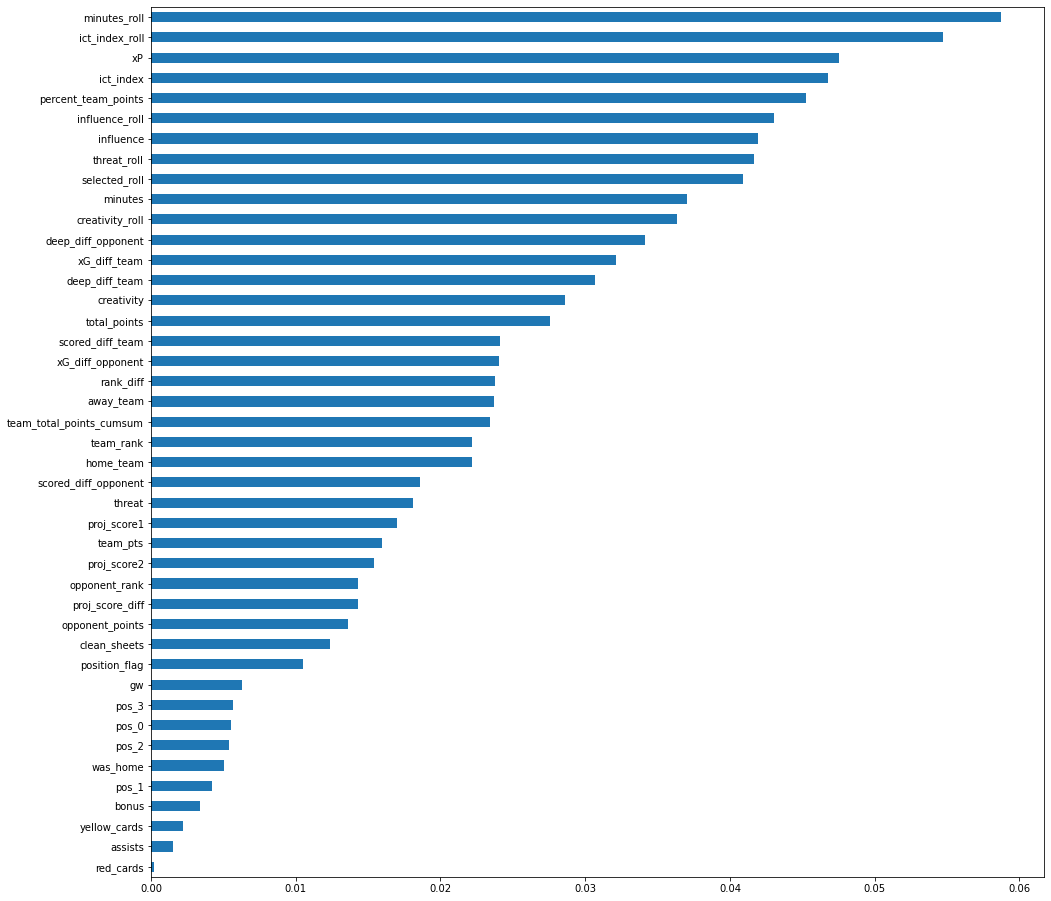

In [94]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

model = RandomForestClassifier(n_estimators=100,max_depth=10, random_state=0,min_samples_split=5,class_weight='balanced_subsample')
model.fit(X_train,Y_train)#Fitting the model 
#Generating predictions from Random Fores Models
pred_rf=model.predict(X_test)
pred_rf_proba=model.predict_proba(X_test)

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances=feat_importances.sort_values()
feat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance

print('Model Accuracy')
print(model.score(X_test,Y_test))

In [95]:
import statistics

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % statistics.mean(scores))

Mean ROC AUC: 0.789


0.2496520447721227


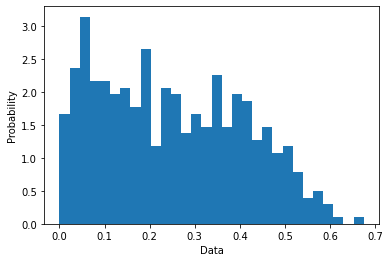

In [96]:
import plotly.express as px
import matplotlib.pyplot as plt

def plot_hist(pred):
  plt.hist(pred[:,1], density=True, bins=30)  # density=False would make counts
  plt.ylabel('Probability')
  plt.xlabel('Data')

plot_hist(pred_rf_proba)
print(pred_rf_proba[:,1].mean())

Predicted    0    1  All
Actual                  
0          151  208  359
1            9   84   93
All        160  292  452


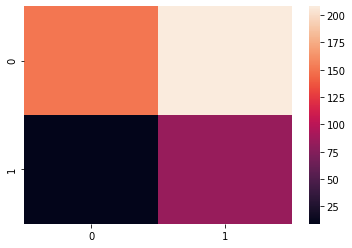

True Positive Rate [0.42061281 0.90322581]


In [97]:
#Confusion Matrix & True Positive Rate
calc_pred=pred_rf_proba[:,1]>0.16
calc_pred=calc_pred.astype(int)

conf_mat = confusion_matrix(Y_test, calc_pred)
df_confusion = pd.crosstab(Y_test, calc_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

#print(conf_mat)

# Visualize it as a heatmap
import seaborn
import matplotlib.pyplot as plt

seaborn.heatmap(conf_mat)
plt.show()

FP = conf_mat.sum(axis=0) - np.diag(conf_mat)  
FN = conf_mat.sum(axis=1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)
TPR = TP/(TP+FN)

print("True Positive Rate",TPR)

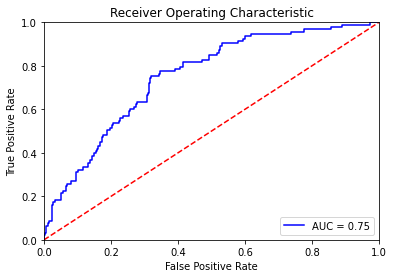

In [98]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


def plot_curve(pred):
  fpr, tpr, threshold = metrics.roc_curve(Y_test, pred[:,1])
  roc_auc = metrics.auc(fpr, tpr)

# method I: plt
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
plot_curve(pred_rf_proba)

In [99]:
# optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), pred_rf_proba)), key=lambda i: i[0], reverse=True)[0][1]
# print(optimal_proba_cutoff)

# roc_predictions=calc_pred=pred_rf_proba[:,1]>0.26
# roc_predictions=roc_predictions.astype(int)

#roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_proba[:, -1]]

In [100]:
# print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(Y_test, roc_predictions), accuracy_score(Y_test, roc_predictions)))
# print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(Y_test, roc_predictions), precision_score(Y_test, roc_predictions)))
# print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(Y_test, roc_predictions), recall_score(Y_test, roc_predictions)))


 XGBoost

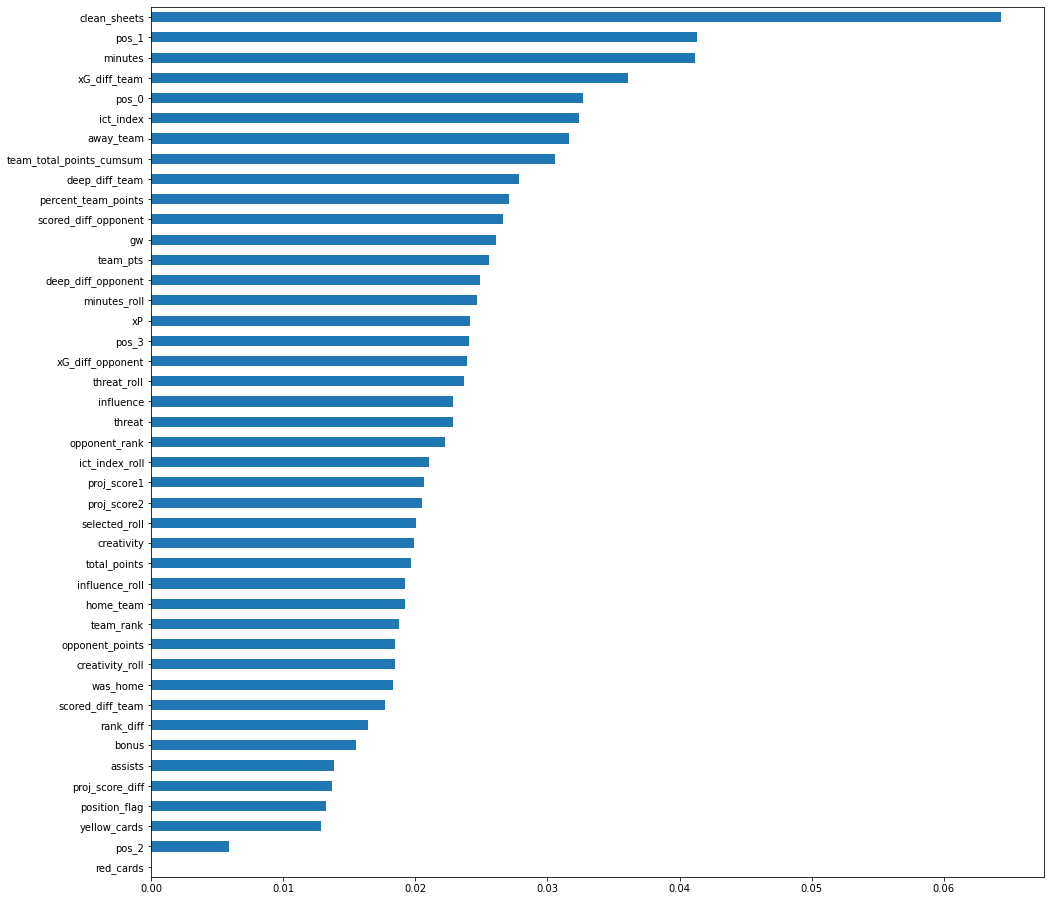

In [101]:
from xgboost import XGBClassifier


model = XGBClassifier(max_depth=7,
   # 'max_leaves' : 2**4,
    alpha=0.1, 
   # 'lambda' : 0.2,
    subsample=0.8,
    learning_rate=0.1, #default = 0.3,
    colsample_bytree=0.7,
    eval_metric='auc', 
    objective = 'binary:logistic',
    grow_policy='lossguide',
    n_estimators=100)
model.fit(X_train, Y_train)
pred_xg_proba=model.predict_proba(X_test)

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances=feat_importances.sort_values()
feat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance



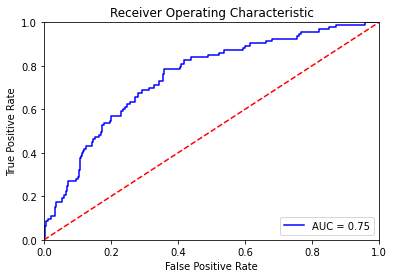

Predicted    0    1  All
Actual                  
0          270   89  359
1           35   58   93
All        305  147  452


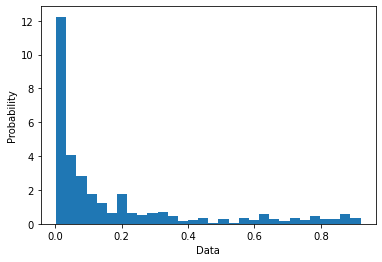

In [102]:
plot_curve(pred_xg_proba)
plot_hist(pred_xg_proba)

calc_pred=pred_xg_proba[:,1]>0.16
calc_pred=calc_pred.astype(int)

conf_mat = confusion_matrix(Y_test, calc_pred)
df_confusion = pd.crosstab(Y_test, calc_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

In [103]:
X_cols=weekly_data_subset_new_agg_pts_team2[['player_name','position','team','total_points','point_flag']].copy()
X_test_pred=pd.merge(X_test, X_cols, left_index=True, right_index=True)
#X_test_pred['predictions']=pred_rf_proba[:,1]
X_test_pred['predictions']=pred_xg_proba[:,1]


In [104]:
X_test_pred.loc[X_test_pred['predictions']>0.5].sort_values(by='predictions',ascending=False).head(20)


,was_home,home_team,away_team,proj_score1,proj_score2,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,red_cards,yellow_cards,xP,total_points_x,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,gw,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,rank_diff,proj_score_diff,team_total_points_cumsum,percent_team_points,position_flag,pos_0,pos_1,pos_2,pos_3,player_name,position,team,total_points_y,point_flag,predictions
598,True,2,6,1.78,0.97,22.015385,0.000000,0.000000,2.192308,83.076923,1.524575e+06,0,0,17.0,25,4,3,0,270,77.6,0.0,0.0,7.7,22,7.0,0.877618,0.605556,0.648649,18,14,10.0,-0.239518,0.471910,0.431818,-3.0,0.81,647,0.038640,2,0,0,1,0,Emiliano Martínez,GK,Aston Villa,25,1,0.919418
951,False,1,5,1.12,1.64,9.466667,0.000000,0.000000,0.958333,75.000000,3.955767e+05,0,0,12.9,10,0,1,0,270,40.0,0.0,0.0,4.1,25,4.0,1.021376,0.608187,0.674419,14,14,12.0,-0.076720,0.561224,0.400000,-8.0,-0.52,729,0.013717,2,0,0,1,0,Edouard Mendy,GK,Chelsea,10,0,0.915200
1150,True,12,14,2.79,0.24,28.000000,44.430769,34.307692,10.684615,77.846154,1.844077e+06,0,1,24.0,12,2,2,1,270,67.8,169.3,93.0,33.0,23,6.0,0.843072,0.739884,0.612903,18,14,10.0,-0.327646,0.357616,0.435897,-4.0,2.55,633,0.018957,3,0,0,0,1,Kevin De Bruyne,MID,Man City,12,1,0.891550
607,True,2,6,1.78,0.97,13.516667,15.916667,4.666667,3.433333,90.000000,1.484582e+05,0,1,10.5,17,0,3,0,270,48.2,48.9,12.0,11.0,22,7.0,0.877618,0.605556,0.648649,18,14,10.0,-0.239518,0.471910,0.431818,-3.0,0.81,647,0.026275,0,1,0,0,0,Matt Targett,DEF,Aston Villa,17,1,0.891510
602,True,2,6,1.78,0.97,16.500000,20.741667,11.083333,4.825000,90.000000,1.272308e+05,0,1,10.2,11,0,3,1,270,21.4,32.1,30.0,8.3,22,7.0,0.877618,0.605556,0.648649,18,14,10.0,-0.239518,0.471910,0.431818,-3.0,0.81,647,0.017002,3,0,0,0,1,John McGinn,MID,Aston Villa,11,1,0.891279
1142,True,12,14,2.79,0.24,15.800000,0.000000,0.000000,1.584615,90.000000,4.256101e+05,0,1,17.2,14,0,2,0,270,49.6,0.0,0.0,5.0,23,6.0,0.843072,0.739884,0.612903,18,14,10.0,-0.327646,0.357616,0.435897,-4.0,2.55,633,0.022117,2,0,0,1,0,Ederson Santana de Moraes,GK,Man City,14,1,0.887368
1156,True,12,14,2.79,0.24,19.123077,15.900000,39.307692,7.438462,76.846154,4.022826e+05,0,0,18.2,18,2,2,1,270,76.2,70.2,144.0,29.1,23,6.0,0.843072,0.739884,0.612903,18,14,10.0,-0.327646,0.357616,0.435897,-4.0,2.55,633,0.028436,3,0,0,0,1,Raheem Sterling,MID,Man City,18,1,0.887002
600,True,2,6,1.78,0.97,35.583333,45.866667,54.666667,13.591667,90.000000,2.167787e+06,0,1,15.5,15,1,3,2,270,63.0,200.7,158.0,42.1,22,7.0,0.877618,0.605556,0.648649,18,14,10.0,-0.239518,0.471910,0.431818,-3.0,0.81,647,0.023184,3,0,0,0,1,Jack Grealish,MID,Aston Villa,15,0,0.877449
802,False,8,16,1.21,1.38,24.700000,0.000000,0.000000,2.478571,90.000000,1.489389e+06,0,0,10.5,12,0,1,0,270,59.0,0.0,0.0,5.9,24,5.0,-0.067726,0.540373,0.568182,10,14,15.0,-0.440986,0.388889,0.361111,-10.0,-0.17,661,0.018154,2,0,0,1,0,Alex McCarthy,GK,Southampton,12,1,0.875847
251,False,9,13,1.47,1.67,44.230769,45.246154,31.307692,12.092308,79.461538,2.214843e+06,0,0,22.0,22,2,1,1,239,117.8,80.5,92.0,29.1,26,3.0,0.305735,0.596774,0.571429,27,14,2.0,0.288467,0.527607,0.604651,1.0,-0.20,578,0.038062,3,0,0,0,1,Bruno Miguel Borges Fernandes,MID,Man Utd,22,1,0.869940


In [105]:
#from google.colab import files

X_test_pred.to_csv('df.csv')
#files.download('df.csv')


In [106]:
weekly_data_subset['round'].max()

15

In [107]:
#Prepare dataset for future game week predictions
fixtures_df1=fixtures_df[['event','team_h','team_a']]
max_week=weekly_data_subset['round'].max()
print(max_week)
pred_data=weekly_data_subset.loc[weekly_data_subset['round']==max_week]
fixtures_df1=fixtures_df1.loc[fixtures_df1['event']==max_week+1]

#fixtures_df1=fixtures_df1.loc[fixtures_df1['event']==max_week]

pred_data=pred_data[['player_name','position','team','team_id','round']].reset_index(drop=True)
pred_data
#fixtures_df

pred_data=pd.merge(left=pred_data,right=fixtures_df1,left_on='team_id',right_on='team_h',how='left')
pred_data=pd.merge(left=pred_data,right=fixtures_df1,left_on='team_id',right_on='team_a',how='left')

pred_data.loc[pred_data['team_h_x'].isna(),'team_h_x']=pred_data.loc[pred_data['team_h_x'].isna(),'team_h_y']
pred_data.loc[pred_data['team_a_x'].isna(),'team_a_x']=pred_data.loc[pred_data['team_a_x'].isna(),'team_a_y']
pred_data=pred_data[['player_name','position','team','team_id','team_h_x','team_a_x','round']]
pred_data=pred_data.rename(columns={"round": "gw","team_h_x": "home_team","team_a_x":"away_team"})

# #weekly_data_subset_new=weekly_data_subset[['player_name','gw','position','team','round','team_id','opponent_id','selected','was_home','home_team','away_team','proj_score1','proj_score2','point_flag']].copy()

# #Home Flag
pred_data['was_home']=0
pred_data.loc[pred_data['home_team']==pred_data['team_id'],'was_home']=1

#TOBECHANGED
pred_data['gw']=GW-1

pred_data['opponent_id']=0

pred_data['opponent_id']=pred_data['home_team']
pred_data.loc[pred_data['was_home']==1,'opponent_id']=pred_data.loc[pred_data['was_home']==1,'away_team']
#pred_data

pred_data_roll=pd.merge(left=pred_data,right=weekly_rolling_means,left_on=['player_name','gw'],right_on=['player_name','gw'],how='inner')

# #Merge cumulative means
pred_data_roll_cum=pd.merge(left=pred_data_roll,right=gp_cumsum,left_on=['player_name','gw'],right_on=['player_name','gw'],how='inner')
#pred_data_roll_cum

# # #Merge team total ranking stats with home team
pred_data_roll_cum_team=pd.merge(left=pred_data_roll_cum,right=team_total_data_id,left_on=['team_id','gw'],right_on=['id','gw'])
pred_data_roll_cum_team=pred_data_roll_cum_team.rename(columns={"rank": "team_rank",'cum_pts':'team_pts','xG_diff':'xG_diff_team','scored_diff':'scored_diff_team','deep_diff':'deep_diff_team'})

# # #Merge team total ranking stats with away team
pred_data_roll_cum_team=pd.merge(left=pred_data_roll_cum_team,right=team_total_data_id,left_on=['opponent_id','gw'],right_on=['id','gw'])
pred_data_roll_cum_team=pred_data_roll_cum_team.rename(columns={"rank": "opponent_rank",'cum_pts':'opponent_points','xG_diff':'xG_diff_opponent','scored_diff':'scored_diff_opponent','deep_diff':'deep_diff_opponent'})
pred_data_roll_cum_team

# #Merge team total ranking stats with away team
pred_data_roll_cum_team_pts=pd.merge(left=pred_data_roll_cum_team,right=team_gp,left_on=['team_id','gw'],right_on=['team_id','round'],how='inner')
pred_data_roll_cum_team_pts['percent_team_points']=pred_data_roll_cum_team_pts['total_points']/pred_data_roll_cum_team_pts['team_total_points_cumsum']
pred_data_roll_cum_team_pts['gw']=max_week+1

pred_data_roll_cum_team_pts_spi=pd.merge(left=pred_data_roll_cum_team_pts,right=spi_data_name_fil,left_on=['home_team','away_team'],right_on=['home_id','away_id'],how='inner')

# #Calculate rank and projected score differences for the upcoming fixture
pred_data_roll_cum_team_pts_spi['rank_diff']=pred_data_roll_cum_team_pts_spi['team_rank']-pred_data_roll_cum_team_pts_spi['opponent_rank']
pred_data_roll_cum_team_pts_spi['proj_score_diff']=pred_data_roll_cum_team_pts_spi['proj_score1']-pred_data_roll_cum_team_pts_spi['proj_score2']

pred_data_roll_cum_team_pts_spi

15


,player_name,position,team,team_id,home_team,away_team,gw,was_home,opponent_id,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,id_x,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,id_y,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,round,team_total_points_cumsum,percent_team_points,team1,team2,home_id,away_id,proj_score1,proj_score2,rank_diff,proj_score_diff
0,Aaron Connolly,FWD,Brighton,3,3.0,1.0,16,1,1.0,4.120000,3.960000,11.133333,1.913333,35.400000,39435.266667,0,0,4.8,3,0,0,0,118,4.0,12.0,34.0,5.0,13,3,12.0,0.332461,0.580460,0.428571,17,1,11.0,-0.092225,0.555024,0.441176,15,537,0.005587,Brighton and Hove Albion,Arsenal,3,1,1.28,1.33,1.0,-0.05
1,Adam Lallana,MID,Brighton,3,3.0,1.0,16,1,1.0,5.693333,13.053333,7.800000,2.626667,49.533333,36359.600000,0,0,4.0,6,0,1,0,220,24.6,53.8,16.0,9.3,13,3,12.0,0.332461,0.580460,0.428571,17,1,11.0,-0.092225,0.555024,0.441176,15,537,0.011173,Brighton and Hove Albion,Arsenal,3,1,1.28,1.33,1.0,-0.05
2,Adam Webster,DEF,Brighton,3,3.0,1.0,16,1,1.0,12.933333,3.893333,11.600000,2.840000,84.000000,146389.666667,0,0,7.6,9,0,1,0,270,57.0,17.8,63.0,13.7,13,3,12.0,0.332461,0.580460,0.428571,17,1,11.0,-0.092225,0.555024,0.441176,15,537,0.016760,Brighton and Hove Albion,Arsenal,3,1,1.28,1.33,1.0,-0.05
3,Alexis Mac Allister,MID,Brighton,3,3.0,1.0,16,1,1.0,3.026667,0.200000,1.000000,0.420000,4.066667,3409.400000,0,0,0.9,1,0,0,0,18,2.0,0.3,8.0,1.0,13,3,12.0,0.332461,0.580460,0.428571,17,1,11.0,-0.092225,0.555024,0.441176,15,537,0.001862,Brighton and Hove Albion,Arsenal,3,1,1.28,1.33,1.0,-0.05
4,Alireza Jahanbakhsh,MID,Brighton,3,3.0,1.0,16,1,1.0,3.333333,5.846667,7.866667,1.700000,11.666667,2996.333333,0,0,3.6,4,0,0,0,112,12.2,43.5,51.0,10.6,13,3,12.0,0.332461,0.580460,0.428571,17,1,11.0,-0.092225,0.555024,0.441176,15,537,0.007449,Brighton and Hove Albion,Arsenal,3,1,1.28,1.33,1.0,-0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Wes Morgan,DEF,Leicester,9,6.0,9.0,16,0,6.0,0.200000,0.006667,0.000000,0.020000,1.066667,9615.666667,0,0,1.0,0,0,0,0,0,0.0,0.0,0.0,0.0,28,9,3.0,0.199594,0.511765,0.595745,18,6,10.0,-0.472420,0.482412,0.404255,15,666,0.000000,Crystal Palace,Leicester City,6,9,1.15,1.65,-7.0,-0.50
356,Wesley Fofana,DEF,Leicester,9,6.0,9.0,16,0,6.0,19.683333,3.125000,3.916667,2.666667,82.500000,27891.750000,0,0,12.7,18,1,2,1,360,94.8,14.1,30.0,13.9,28,9,3.0,0.199594,0.511765,0.595745,18,6,10.0,-0.472420,0.482412,0.404255,15,666,0.027027,Crystal Palace,Leicester City,6,9,1.15,1.65,-7.0,-0.50
357,Wilfred Ndidi,MID,Leicester,9,6.0,9.0,16,0,6.0,8.586667,2.300000,0.533333,1.140000,36.666667,63352.866667,0,2,6.6,9,1,2,0,349,73.2,22.1,8.0,10.3,28,9,3.0,0.199594,0.511765,0.595745,18,6,10.0,-0.472420,0.482412,0.404255,15,666,0.013514,Crystal Palace,Leicester City,6,9,1.15,1.65,-7.0,-0.50
358,Youri Tielemans,MID,Leicester,9,6.0,9.0,16,0,6.0,19.373333,10.606667,11.133333,4.120000,90.000000,164741.000000,0,0,10.2,11,1,2,0,360,36.0,30.4,32.0,10.0,28,9,3.0,0.199594,0.511765,0.595745,18,6,10.0,-0.472420,0.482412,0.404255,15,666,0.016517,Crystal Palace,Leicester City,6,9,1.15,1.65,-7.0,-0.50


In [108]:
pred_data_roll_cum_team_pts_spi['position_flag'] = labelencoder.fit_transform(pred_data_roll_cum_team_pts_spi['position'])
cols = pd.get_dummies(pred_data_roll_cum_team_pts_spi['position_flag'])
cols.columns = ['pos_0','pos_1','pos_2','pos_3']
pred_data_roll_cum_team_pts_spi1 = pd.concat([pred_data_roll_cum_team_pts_spi, cols], axis=1)
pred_data_roll_cum_team_pts_spi1

pred_data_roll_cum_team_pts_spi1.drop(['player_name','position','team','team1','team2','away_id','home_id','id_x','id_y','opponent_id','team_id','round'],axis=1,inplace=True)

#Reorder columns in the test data to be in the same order as train data
pred_data_roll_cum_team_pts_spi1=pred_data_roll_cum_team_pts_spi1[X_train.columns]
proba=model.predict_proba(pred_data_roll_cum_team_pts_spi1)
pred_data_roll_cum_team_pts_spi['predicted']=proba[:,1]

In [109]:
pred_data_roll_cum_team_pts_spi.sort_values(by='predicted',ascending=False).head(15)

,player_name,position,team,team_id,home_team,away_team,gw,was_home,opponent_id,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,id_x,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,id_y,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,round,team_total_points_cumsum,percent_team_points,team1,team2,home_id,away_id,proj_score1,proj_score2,rank_diff,proj_score_diff,position_flag,predicted
179,Alisson Ramses Becker,GK,Liverpool,11,14.0,11.0,16,0,14.0,17.480000,0.000000,0.000000,1.746667,72.000000,6.109099e+05,0,0,15.2,14,0,1,0,360,89.4,0.0,0.0,8.9,32,11,1.0,0.753669,0.781250,0.649123,18,14,10.0,-0.518156,0.327485,0.414634,15,746,0.018767,Newcastle,Liverpool,14,11,0.86,2.28,-9.0,-1.42,2,0.936316
232,Emiliano Martínez,GK,Aston Villa,2,5.0,2.0,16,0,5.0,22.885714,0.000000,0.000000,2.278571,83.571429,1.574171e+06,0,0,24.2,35,6,4,0,360,111.8,0.0,0.0,11.1,25,2,6.0,1.097267,0.587065,0.675000,25,5,6.0,0.973904,0.603261,0.638298,15,720,0.048611,Chelsea,Aston Villa,5,2,1.93,1.08,0.0,0.85,2,0.931235
253,Edouard Mendy,GK,Chelsea,5,5.0,2.0,16,1,2.0,11.323077,0.000000,0.000000,1.146154,76.153846,4.184272e+05,0,0,16.2,12,0,1,0,360,73.6,0.0,0.0,7.5,25,5,6.0,0.973904,0.603261,0.638298,25,2,6.0,1.097267,0.587065,0.675000,15,752,0.015957,Chelsea,Aston Villa,5,2,1.93,1.08,0.0,0.85,2,0.929881
185,Fabio Henrique Tavares,MID,Liverpool,11,14.0,11.0,16,0,14.0,15.706667,3.560000,0.666667,2.006667,74.133333,8.597020e+04,0,0,15.8,11,2,1,0,360,91.2,9.0,1.0,10.1,32,11,1.0,0.753669,0.781250,0.649123,18,14,10.0,-0.518156,0.327485,0.414634,15,746,0.014745,Newcastle,Liverpool,14,11,0.86,2.28,-9.0,-1.42,3,0.908351
180,Andrew Robertson,DEF,Liverpool,11,14.0,11.0,16,0,14.0,23.013333,30.900000,10.733333,6.473333,90.000000,1.253822e+06,0,0,26.1,19,1,1,2,360,104.6,178.5,20.0,30.3,32,11,1.0,0.753669,0.781250,0.649123,18,14,10.0,-0.518156,0.327485,0.414634,15,746,0.025469,Newcastle,Liverpool,14,11,0.86,2.28,-9.0,-1.42,0,0.895474
188,Joel Matip,DEF,Liverpool,11,14.0,11.0,16,0,14.0,10.813333,2.653333,5.600000,1.906667,37.000000,5.141780e+04,0,0,21.4,17,3,1,2,194,76.2,26.9,25.0,12.8,32,11,1.0,0.753669,0.781250,0.649123,18,14,10.0,-0.518156,0.327485,0.414634,15,746,0.022788,Newcastle,Liverpool,14,11,0.86,2.28,-9.0,-1.42,0,0.891558
189,Jordan Henderson,MID,Liverpool,11,14.0,11.0,16,0,14.0,15.026667,11.586667,5.533333,3.220000,63.666667,1.021539e+05,0,0,19.5,14,0,1,0,360,115.0,53.5,33.0,20.1,32,11,1.0,0.753669,0.781250,0.649123,18,14,10.0,-0.518156,0.327485,0.414634,15,746,0.018767,Newcastle,Liverpool,14,11,0.86,2.28,-9.0,-1.42,3,0.891182
186,Georginio Wijnaldum,MID,Liverpool,11,14.0,11.0,16,0,14.0,11.333333,11.106667,7.400000,2.986667,82.600000,1.076885e+05,0,0,21.3,13,1,1,1,338,43.8,71.8,18.0,13.3,32,11,1.0,0.753669,0.781250,0.649123,18,14,10.0,-0.518156,0.327485,0.414634,15,746,0.017426,Newcastle,Liverpool,14,11,0.86,2.28,-9.0,-1.42,3,0.880143
191,Mohamed Salah,MID,Liverpool,11,14.0,11.0,16,0,14.0,39.866667,25.133333,50.200000,11.513333,77.866667,2.792237e+06,0,0,35.8,33,3,0,1,296,175.8,56.7,169.0,40.1,32,11,1.0,0.753669,0.781250,0.649123,18,14,10.0,-0.518156,0.327485,0.414634,15,746,0.044236,Newcastle,Liverpool,14,11,0.86,2.28,-9.0,-1.42,3,0.865753
200,Trent Alexander-Arnold,DEF,Liverpool,11,14.0,11.0,16,0,14.0,14.760000,24.953333,8.533333,4.820000,69.933333,2.008696e+06,0,0,11.3,15,0,1,1,337,75.4,148.7,35.0,25.9,32,11,1.0,0.753669,0.781250,0.649123,18,14,10.0,-0.518156,0.327485,0.414634,15,746,0.020107,Newcastle,Liverpool,14,11,0.86,2.28,-9.0,-1.42,0,0.864077


In [110]:
pred_data_roll_cum_team_pts_spi.to_csv('pred.csv')
#files.download('pred.csv')

In [111]:
pred_data_roll_cum_team_pts_spi.sort_values(by='predicted',ascending=False,inplace=True)

team_list=[]

gk=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='GK',['player_name','position','team_id','gw']].head(1)
team_list.append(gk)

defender=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='DEF',['player_name','position','team_id','gw']].head(3)
team_list.append(defender)
midfielder=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='MID',['player_name','position','team_id','gw']].head(4)
team_list.append(midfielder)
forward=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='FWD',['player_name','position','team_id','gw']].head(3)
team_list.append(forward)

team_list

[               player_name position  team_id  gw
 179  Alisson Ramses Becker       GK       11  16,
                 player_name position  team_id  gw
 180        Andrew Robertson      DEF       11  16
 188              Joel Matip      DEF       11  16
 200  Trent Alexander-Arnold      DEF       11  16,
                 player_name position  team_id  gw
 185  Fabio Henrique Tavares      MID       11  16
 189        Jordan Henderson      MID       11  16
 186     Georginio Wijnaldum      MID       11  16
 191           Mohamed Salah      MID       11  16,
          player_name position  team_id  gw
 196  Roberto Firmino      FWD       11  16
 269      Timo Werner      FWD        5  16
 134  Anthony Martial      FWD       13  16]

In [112]:

output=pd.concat(team_list)

output['web_name'] = output['player_name'].str.split(' ').str[1]
player_photo=players_df[['first_name','second_name','photo','code','team']].copy()
player_photo['web_name']=player_photo['first_name']+' '+player_photo['second_name']
player_photo
output_join=pd.merge(left=output,right=player_photo,left_on=['player_name','team_id'],right_on=['web_name','team'],how='left')
output_join=output_join[['player_name','position','photo','gw']]
output_join['new_photo']=output_join['photo'].str.split('.').str[0]
del output_join['photo']
output_join.to_csv('output.csv',index=False)
files.download('output.csv')

#output_join


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [113]:
#Appending to the predictions file
output_file=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/FPLBot/main/output.csv')
# output_file

final_output=output_join.append(output_file, ignore_index=True)
final_output.to_csv('output.csv',index=False)
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [114]:
#Past actual game week scores for my dream team
last_gw_team=output_file.loc[output_file.gw==GW-1]
last_gw_team

weekly_data_last=weekly_data_team[['player_name','total_points','gw','position']]
weekly_data_last=weekly_data_last.loc[weekly_data_last.gw==GW-1]

last_gw_team_pts=pd.merge(left=last_gw_team,right=weekly_data_last,left_on=['player_name','gw','position'],right_on=['player_name','gw','position'],how='inner')
last_gw_team_pts

last_gw_team_pts.to_csv('gw_points_history.csv',index=False)
files.download('gw_points_history.csv')

#Dream Team past GW
weekly_data_last.sort_values(by=['total_points'],ascending=False,inplace=True)
weekly_data_last.head(10)

dream_team_list=[]
gk=weekly_data_last.loc[weekly_data_last['position']=='GK',['player_name','position','total_points']].head(1)
dream_team_list.append(gk)

defender=weekly_data_last.loc[weekly_data_last['position']=='DEF',['player_name','position','total_points']].head(3)
dream_team_list.append(defender)
midfielder=weekly_data_last.loc[weekly_data_last['position']=='MID',['player_name','position','total_points']].head(4)
dream_team_list.append(midfielder)
forward=weekly_data_last.loc[weekly_data_last['position']=='FWD',['player_name','position','total_points']].head(3)
dream_team_list.append(forward)

last_gw_dream_team=pd.concat(dream_team_list)
last_gw_dream_team.to_csv('last_gw_dream_team.csv',index=False)
files.download('last_gw_dream_team.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [115]:
avg_score_df=events_df.loc[events_df.id<=GW]
avg_score_df=avg_score_df[['id','average_entry_score']]

avg_score_df.to_csv('avg_score_df.csv',index=False)
files.download('avg_score_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [122]:
#output_join.iloc[0,2]


# img=output_join.iloc[0,2]
# img_path='https://resources.premierleague.com/premierleague/photos/players/110x140/p'+img+'.png'
# print(img_path)
# from skimage import io
# io.imshow(io.imread(img_path))
# #io.show()
#import plotly
import skimage
#skimage.io.show()
#from skimage import io
print(seaborn.__version__)

0.11.0
